# MLFlow Part 1

In [ ]:
!pip install -q mlflow

In [ ]:
!apt-get install tree

In [ ]:
from utils import start_mlflow

---

## Simple Sklearn Experiment

Load dataset

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

dataset = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.4)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Train model locally

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Train your classifier with MLFlow support

In [ ]:
import mlflow
from sklearn.linear_model import LogisticRegression

# enable autologging
mlflow.sklearn.autolog()

with mlflow.start_run():
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

mlflow.sklearn.autolog(disable=True)

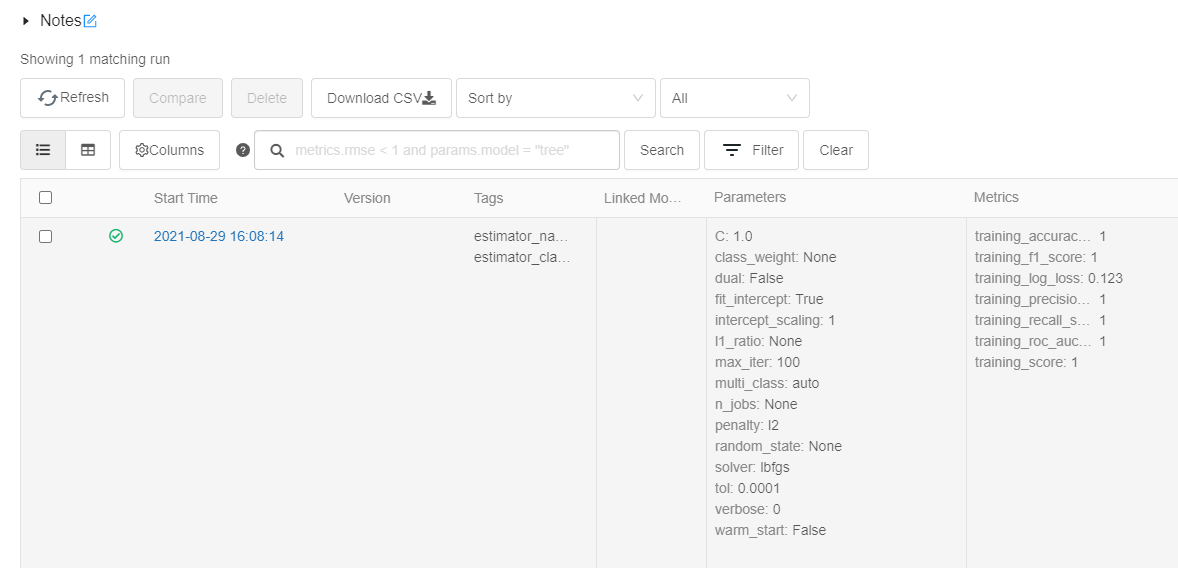

## Stock Prediction

We will prototype a simple stock prediction project in this section with MLflow and will document the different files and phases of the solution. 

The task in this illustrative project is to create a basic MLflow project and produce a working baseline ML model to predict, based on market signals over a certain number of days, whether the stock market will go up or down.

In this section, we will use a Yahoo Finance dataset available for quoting the BTC-USD pair in https://finance.yahoo.com/quote/BTC-USD/ over a period of 3 months. We will train a model to predict whether the quote will be going up or not on a given day. A REST API will be made available for predictions through MLflow.

### Problem Statement

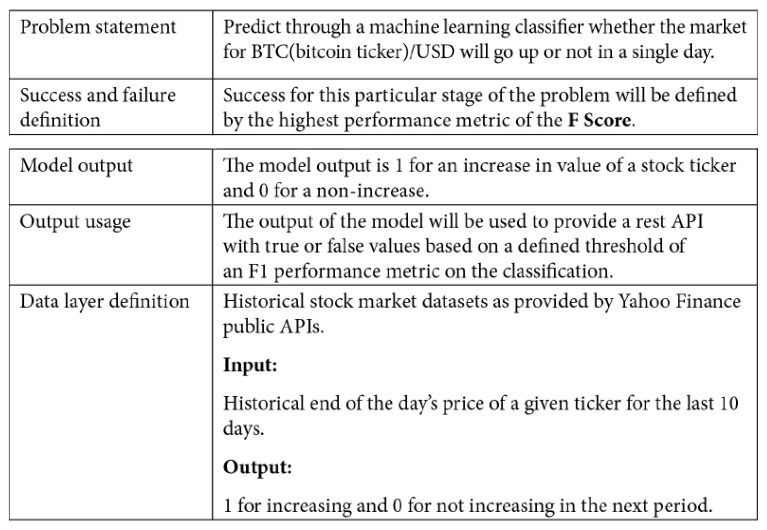

### Setup ML Project
An MLflow project represents the basic unit of organization of ML projects. It is a format for packaging data science code in a reusable and reproducible way, based primarily on conventions. In addition, the Projects component includes an API and command-line tools for running projects, making it possible to chain together projects into workflows.

At the core, MLflow Projects are just a convention for organizing and describing your code to let other data scientists (or automated tools) run it. Each project is simply a directory of files, or a Git repository, containing your code. MLflow can run some projects based on a convention for placing files in this directory (for example, a conda.yaml file is treated as a Conda environment), but you can describe your project in more detail by adding a MLproject file, which is a YAML formatted text file. There are three different environments supported by MLflow projects: the Conda environment, Docker, and the local system. 

Model details of the different parameters available on an MLProject file can be consulted in the official documentation available at https://www.mlflow.org/docs/latest/projects.html#running-projects.

In [ ]:
!mkdir -p stockpred
%cd stockpred

/content/reco-tut-de/code/mlflow/stockpred


In [ ]:
mlflow_ui_stockpred = start_mlflow()
mlflow_ui_stockpred

'https://f4b71ux5biq-496ff2e9c6d22116-20113-colab.googleusercontent.com/'

In [ ]:
!dvc add ./mlruns

In [ ]:
%%writefile MLproject
name: stockpred

entry_points:
  main:
    command: "python train.py"

Writing MLproject


### Building the Experiment

In [ ]:
import warnings
import numpy as np
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")

In [ ]:
data_path = '../../../data/bronze/stockpred/test.csv'

In [ ]:
def acquire_training_data(datafile):
    df = pd.read_csv(datafile)
    return df

def digitize(n):
    if n > 0:
        return 1
    return 0

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def prepare_training_data(data):
    data['Delta'] = data['Close'] - data['Open']
    data['to_predict'] = data['Delta'].apply(lambda d: digitize(d))
    return data

In [ ]:
training_data = acquire_training_data(data_path)

prepared_training_data_df = prepare_training_data(training_data)
btc_mat = prepared_training_data_df.to_numpy()

WINDOW_SIZE = 14
X = rolling_window(btc_mat[:, 7], WINDOW_SIZE)[:-1, :]
Y = prepared_training_data_df['to_predict'].to_numpy()[WINDOW_SIZE:]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=4284, stratify=Y)

clf = RandomForestClassifier(bootstrap=True, criterion='gini', min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=50, random_state=4284, verbose=0)
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.53      0.82      0.64        11
           1       0.33      0.11      0.17         9

    accuracy                           0.50        20
   macro avg       0.43      0.46      0.40        20
weighted avg       0.44      0.50      0.43        20



### Package the experiment script as per MLflow standards

In [ ]:
%%writefile train.py
import warnings

import numpy as np
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import mlflow.sklearn


data_path = '../../../data/bronze/stockpred/test.csv'


def acquire_training_data(datafile):
    df = pd.read_csv(datafile)
    return df


def digitize(n):
    if n > 0:
        return 1
    return 0


def rolling_window(a, window):
    """
        Takes np.array 'a' and size 'window' as parameters
        Outputs an np.array with all the ordered sequences of values of 'a' of size 'window'
        e.g. Input: ( np.array([1, 2, 3, 4, 5, 6]), 4 )
             Output: 
                     array([[1, 2, 3, 4],
                           [2, 3, 4, 5],
                           [3, 4, 5, 6]])
    """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def prepare_training_data(data):

    """
        Return a prepared numpy dataframe
        input : Dataframe with expected schema
    """
    data['Delta'] = data['Close'] - data['Open']
    data['to_predict'] = data['Delta'].apply(lambda d: digitize(d))
    return data


if __name__ == "__main__":
    warnings.filterwarnings("ignore")

    with mlflow.start_run():

        training_data = acquire_training_data(data_path)

        prepared_training_data_df = prepare_training_data(training_data)

        btc_mat = prepared_training_data_df.to_numpy()

        WINDOW_SIZE = 14

        X = rolling_window(btc_mat[:, 7], WINDOW_SIZE)[:-1, :]
        Y = prepared_training_data_df['to_predict'].to_numpy()[WINDOW_SIZE:]

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=4284, stratify=Y)

        clf = RandomForestClassifier(bootstrap=True, criterion='gini', min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=50, random_state=4284, verbose=0)

        clf.fit(X_train, y_train)

        predicted = clf.predict(X_test)

        mlflow.sklearn.log_model(clf, "model_random_forest")

        print(classification_report(y_test, predicted))

        mlflow.log_metric("precision_label_0", precision_score(y_test, predicted, pos_label=0))
        mlflow.log_metric("recall_label_0", recall_score(y_test, predicted, pos_label=0))
        mlflow.log_metric("f1score_label_0", f1_score(y_test, predicted, pos_label=0))
        mlflow.log_metric("precision_label_1", precision_score(y_test, predicted, pos_label=1))
        mlflow.log_metric("recall_label_1", recall_score(y_test, predicted, pos_label=1))
        mlflow.log_metric("f1score_label_1", f1_score(y_test, predicted, pos_label=1))

Overwriting train.py


### Run the experiment

In [ ]:
!mlflow run . --no-conda

2021/08/29 11:53:56 INFO mlflow.projects.utils: === Created directory /tmp/tmptm39md7g for downloading remote URIs passed to arguments of type 'path' ===
2021/08/29 11:53:56 INFO mlflow.projects.backend.local: === Running command 'python train.py' in run with ID '171c9a92610d49f4b15ac516f9e9d29d' === 
              precision    recall  f1-score   support

           0       0.53      0.82      0.64        11
           1       0.33      0.11      0.17         9

    accuracy                           0.50        20
   macro avg       0.43      0.46      0.40        20
weighted avg       0.44      0.50      0.43        20

2021/08/29 11:54:01 INFO mlflow.projects: === Run (ID '171c9a92610d49f4b15ac516f9e9d29d') succeeded ===


At this stage, you have a simple, reproducible baseline of a stock predictor pipeline using MLflow that you can improve on and easily share with others.

### MLflow Tracking

In [ ]:
print('Tracking URI: {}'.format(mlflow_ui_stockpred))

Tracking URI: https://f4b71ux5biq-496ff2e9c6d22116-20113-colab.googleusercontent.com/


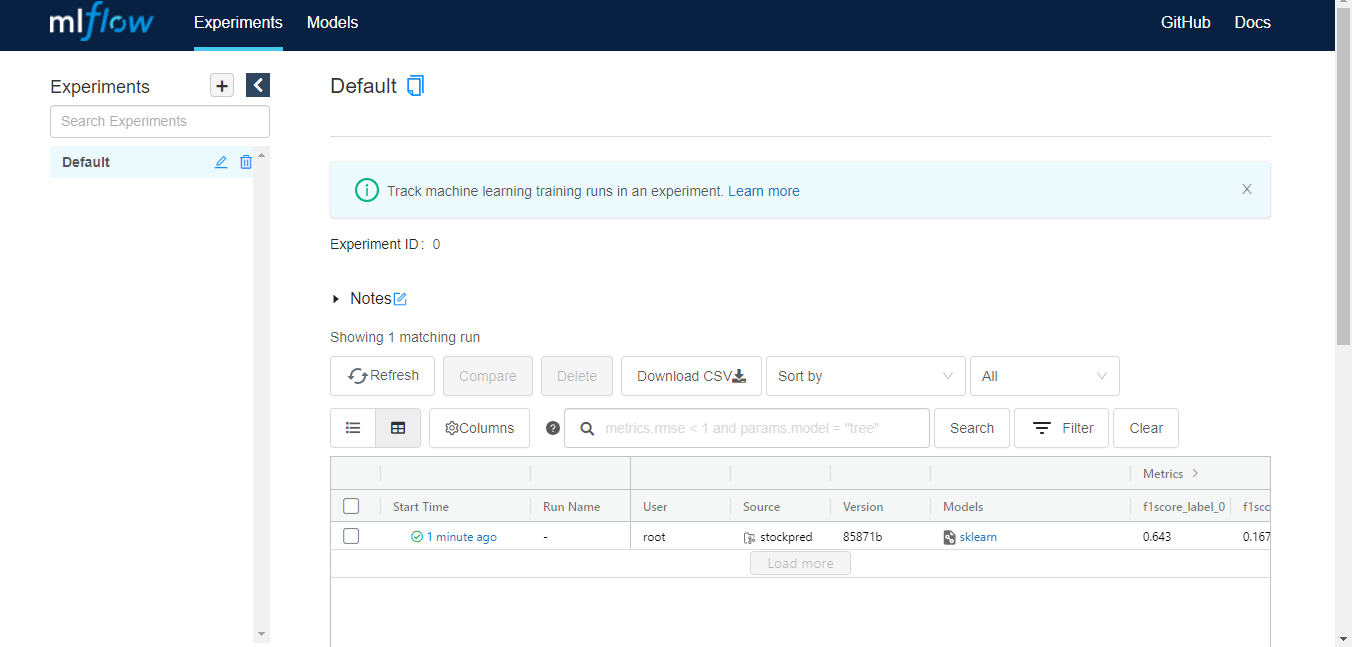

### MLflow Models
MLflow Models is the core component that handles the different model flavors that are supported in MLflow and intermediates the deployment into different execution environments.

In [ ]:
!tree .

.
├── MLproject
├── mlruns
│   └── 0
│       ├── 171c9a92610d49f4b15ac516f9e9d29d
│       │   ├── artifacts
│       │   │   └── model_random_forest
│       │   │       ├── conda.yaml
│       │   │       ├── MLmodel
│       │   │       ├── model.pkl
│       │   │       └── requirements.txt
│       │   ├── meta.yaml
│       │   ├── metrics
│       │   │   ├── f1score_label_0
│       │   │   ├── f1score_label_1
│       │   │   ├── precision_label_0
│       │   │   ├── precision_label_1
│       │   │   ├── recall_label_0
│       │   │   └── recall_label_1
│       │   ├── params
│       │   └── tags
│       │       ├── mlflow.gitRepoURL
│       │       ├── mlflow.log-model.history
│       │       ├── mlflow.project.backend
│       │       ├── mlflow.project.entryPoint
│       │       ├── mlflow.source.git.commit
│       │       ├── mlflow.source.git.repoURL
│       │       ├── mlflow.source.name
│       │       ├── mlflow.source.type
│       │       └── mlflow.user
│       └── meta.yaml
├──

Model predictions

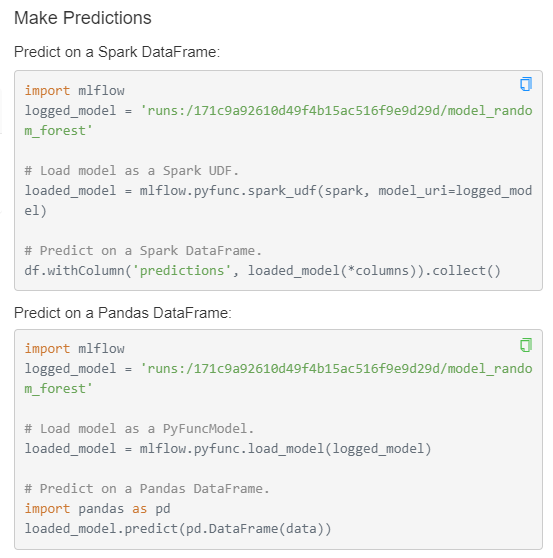

Model serving

In [ ]:
logged_model = 'runs:/171c9a92610d49f4b15ac516f9e9d29d/model_random_forest'
!nohup mlflow models serve -m {logged_model} -p 5003 --no-conda &

nohup: appending output to 'nohup.out'


You have access to a very simple web server that can run your model. Your model prediction interface can be executed by running the following command:

In [ ]:
!curl http://127.0.0.1:5003/invocations -H 'Content-Type: application/json' -d '{"data":[[1,1,1,1,0,1,1,1,0,1,1,1,0,0]]}'

[1]

The response to the API call to our model was 1; as defined in our predicted variable, this means that in the next reading, the stock will move up.

### MLflow Model Registry
The model registry component in MLflow gives the ML developer an abstraction for model life cycle management. It is a centralized store for an organization or function that allows models in the organization to be shared, created, and archived collaboratively.